In [1]:
import sys
print(sys.executable)


c:\Users\rober\.conda\envs\turbine_ai\python.exe


# Health Index Multi-Task LSTM

This notebook demonstrates the multi-task extension of the EOL-LSTM that:

1. **Predicts RUL** (as before)
2. **Predicts a continuous Health Index (HI ∈ [0,1])** - learned as a monotone proxy from RUL during training, but at inference time depends only on sensor features
3. **Uses weighted RUL loss** that emphasizes small RUL (near EOL) during training

**Key Features:**
- Backward compatible: existing single-task training still works
- Multi-task mode enabled via config flag
- Health Index is trained as proxy from RUL, but inference uses only sensor features
- RUL loss is weighted so errors near EOL are penalized more strongly


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

try:
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader
except ImportError as exc:
    raise ImportError(
        "PyTorch is required for this notebook. Please install torch."
    ) from exc

torch.manual_seed(42)

import sys
root_dir = os.path.abspath("..")
if root_dir not in sys.path:
    sys.path.append(root_dir)

from src.config import (
    CMAPSS_DATASETS,
    MAX_RUL,
    USE_HEALTH_HEAD,
    HEALTH_LOSS_WEIGHT,
    RUL_WEIGHTING_TAU,
)
from src.data_loading import load_cmapps_subset
from src.additional_features import (
    create_physical_features,
    create_all_features,
    FeatureConfig,
    TemporalFeatureConfig,
)
from src.eol_full_lstm import (
    build_full_eol_sequences_from_df,
    create_full_dataloaders,
    EOLFullLSTM,
    EOLFullLSTMWithHealth,
    train_eol_full_lstm,
    evaluate_eol_full_lstm,
    evaluate_on_test_data,
)
from src.eval_utils import forward_rul_only, compare_with_benchmarks
from src.loss import multitask_rul_health_loss


In [2]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


## Configuration

Configure whether to use single-task (RUL only) or multi-task (RUL + Health Index) mode.


In [3]:
# ===================================================================
# Configuration: Multi-Task Health Index
# ===================================================================

# Enable multi-task mode (RUL + Health Index)
USE_HEALTH_HEAD = True  # Set to False for single-task mode (backward compatible)

# Multi-task loss parameters
HEALTH_LOSS_WEIGHT = 0.3  # lambda_health: trade-off between RUL and health loss
RUL_WEIGHTING_TAU = 40.0  # tau: scale parameter for exponential RUL weighting

# Training configuration
TRAINING_CONFIG = {
    "past_len": 30,
    "max_rul": MAX_RUL,
    "batch_size": 32,
    "engine_train_ratio": 0.8,
    "num_epochs": 50,
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "patience": 8,
    "hidden_dim": 64,
    "num_layers": 2,
    "dropout": 0.1,
    "bidirectional": False,
}

# Feature configuration
FEATURE_CONFIG = FeatureConfig(
    add_physical_core=True,
    add_temporal_features=True,
    temporal=TemporalFeatureConfig(
        base_cols=None,  # Auto-infer
        short_windows=(5, 10),
        long_windows=(30,),
        add_rolling_mean=True,
        add_rolling_std=False,
        add_trend=True,
        add_delta=True,
        delta_lags=(5, 10),
    ),
)

# Dataset to use
FD_DATASETS = ["FD004"]  #"FD001","FD002","FD003",, Start with FD001 for demonstration

print("=" * 80)
print("Configuration")
print("=" * 80)
print(f"Multi-task mode (Health Head): {USE_HEALTH_HEAD}")
if USE_HEALTH_HEAD:
    print(f"  Health loss weight (lambda): {HEALTH_LOSS_WEIGHT}")
    print(f"  RUL weighting tau: {RUL_WEIGHTING_TAU}")
print(f"Max RUL: {MAX_RUL}")
print(f"Datasets: {FD_DATASETS}")
print("=" * 80)


Configuration
Multi-task mode (Health Head): True
  Health loss weight (lambda): 0.3
  RUL weighting tau: 40.0
Max RUL: 125
Datasets: ['FD004']


## Training: Single-Task vs Multi-Task Comparison

Train both models and compare their performance.


In [4]:
# ===================================================================
# Training: Compare Single-Task vs Multi-Task
# ===================================================================

results = {}

for fd_id in FD_DATASETS:
    print("\n" + "=" * 80)
    print(f"Processing {fd_id}")
    print("=" * 80)
    
    results[fd_id] = {}
    
    # Load data
    print(f"\n[{fd_id}] Loading data...")
    df_train, df_test, y_test_true = load_cmapps_subset(
        fd_id,
        max_rul=None,
        clip_train=False,
        clip_test=True,
    )
    
    # Feature engineering
    print(f"\n[{fd_id}] Feature engineering...")
    from src.config import PhysicsFeatureConfig
    physics_config = PhysicsFeatureConfig(
        use_core=True,
        use_extended=False,
        use_residuals=False,
        use_temporal_on_physics=False,
    )
    
    df_train = create_physical_features(
        df_train,
        physics_config=physics_config,
        unit_col="UnitNumber",
        cycle_col="TimeInCycles",
    )
    df_train = create_all_features(
        df_train,
        unit_col="UnitNumber",
        cycle_col="TimeInCycles",
        config=FEATURE_CONFIG,
        inplace=False,
    )
    
    # Apply same features to test data
    df_test = create_physical_features(
        df_test,
        physics_config=physics_config,
        unit_col="UnitNumber",
        cycle_col="TimeInCycles",
    )
    df_test = create_all_features(
        df_test,
        unit_col="UnitNumber",
        cycle_col="TimeInCycles",
        config=FEATURE_CONFIG,
        inplace=False,
    )
    
    # Get feature columns (exclude RUL-related and helper columns)
    from src.feature_safety import remove_rul_leakage
    feature_cols = [c for c in df_train.columns if c not in ["UnitNumber", "TimeInCycles", "RUL", "RUL_raw", "MaxTime"]]
    feature_cols, leaked = remove_rul_leakage(feature_cols)
    print(f"  Using {len(feature_cols)} features")
    
    # Build sequences
    print(f"\n[{fd_id}] Building sequences...")
    X_full, y_full, unit_ids_full, cond_ids_full = build_full_eol_sequences_from_df(
        df=df_train,
        feature_cols=feature_cols,
        past_len=TRAINING_CONFIG["past_len"],
        max_rul=TRAINING_CONFIG["max_rul"],
        unit_col="UnitNumber",
        cycle_col="TimeInCycles",
        rul_col="RUL",
    )
    
    # Create dataloaders
    print(f"\n[{fd_id}] Creating dataloaders...")
    train_loader, val_loader, scaler, _, _ = create_full_dataloaders(
        X=X_full,
        y=y_full,
        unit_ids=unit_ids_full,
        cond_ids=cond_ids_full,
        batch_size=TRAINING_CONFIG["batch_size"],
        engine_train_ratio=TRAINING_CONFIG["engine_train_ratio"],
        shuffle_engines=True,
        random_seed=42,
    )
    
    # Train both models for comparison
    for mode_name, use_health in [("multi_task", True)]: #("single_task", False), 
        print(f"\n{'='*80}")
        print(f"[{fd_id}] Training {mode_name.upper()} model")
        print(f"{'='*80}")
        
        # Initialize model
        if use_health:
            model = EOLFullLSTMWithHealth(
                input_dim=len(feature_cols),
                hidden_dim=TRAINING_CONFIG["hidden_dim"],
                num_layers=TRAINING_CONFIG["num_layers"],
                dropout=TRAINING_CONFIG["dropout"],
                bidirectional=TRAINING_CONFIG["bidirectional"],
                lambda_health=HEALTH_LOSS_WEIGHT,
            )
        else:
            model = EOLFullLSTM(
                input_dim=len(feature_cols),
                hidden_dim=TRAINING_CONFIG["hidden_dim"],
                num_layers=TRAINING_CONFIG["num_layers"],
                dropout=TRAINING_CONFIG["dropout"],
                bidirectional=TRAINING_CONFIG["bidirectional"],
            )
        
        # Train
        model, history = train_eol_full_lstm(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=TRAINING_CONFIG["num_epochs"],
            lr=TRAINING_CONFIG["lr"],
            weight_decay=TRAINING_CONFIG["weight_decay"],
            patience=TRAINING_CONFIG["patience"],
            device=device,
            results_dir=f"../results/health_index/{fd_id.lower()}/{mode_name}",
            run_name=f"{fd_id.lower()}_{mode_name}",
            use_health_head=use_health,
            max_rul=TRAINING_CONFIG["max_rul"],
            tau=RUL_WEIGHTING_TAU,
            lambda_health=HEALTH_LOSS_WEIGHT,
        )
        
        # Evaluate on validation set
        print(f"\n[{fd_id}] [{mode_name}] Evaluating on validation set...")
        metrics_val = evaluate_eol_full_lstm(
            model=model,
            val_loader=val_loader,
            device=device,
        )
        
        # Evaluate on test set
        print(f"\n[{fd_id}] [{mode_name}] Evaluating on test set...")
        metrics_test = evaluate_on_test_data(
            model=model,
            df_test=df_test,
            y_test_true=y_test_true,
            feature_cols=feature_cols,
            scaler=scaler,
            past_len=TRAINING_CONFIG["past_len"],
            max_rul=TRAINING_CONFIG["max_rul"],
            device=device,
        )
        
        # Store results
        results[fd_id][mode_name] = {
            "model": model,
            "history": history,
            "metrics_val": metrics_val,
            "metrics_test": metrics_test,
            "scaler": scaler,
            "feature_cols": feature_cols,
        }
        
        # Print comparison with benchmarks
        print(f"\n[{fd_id}] [{mode_name}] Test Set Metrics:")
        compare_with_benchmarks(metrics_test["pointwise"], fd_id, print_output=True)
        
        print(f"\n[{fd_id}] [{mode_name}] Completed!")
        print("=" * 80)



Processing FD004

[FD004] Loading data...
[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]

[FD004] Feature engineering...
  Using 245 features

[FD004] Building sequences...
[build_full_eol_sequences_from_df] Summary
Num units: 249
Using past_len=30, max_rul=125
Num feature cols: 245
X shape: torch.Size([54028, 30, 245]), y shape: torch.Size([54028]), unit_ids shape: torch.Size([54028]), cond_ids shape: torch.Size([54028])
RUL stats (capped at 125): min=0.00, max=125.00, mean=88.73, std=41.48
ConditionIDs: [0, 1, 2, 3, 4, 5, 6]

[FD004] Creating dataloaders...
[create_full_dataloaders] Engine-based split
Total units: 249
Train units: 199, Val units: 50
Train samples: 42792, Val samples: 11236
Feature scaling: Condition-wise StandardScaler (7 conditions)
  Conditions: [0, 1, 2, 3, 4, 5, 6]

[FD004] Training MULTI_TASK model
[train_eol_full_lstm] Multi-task mode: RUL + He

In [5]:
# ===================================================================
# Results Comparison: Single-Task vs Multi-Task
# ===================================================================

print("\n" + "=" * 80)
print("COMPARISON: Single-Task vs Multi-Task")
print("=" * 80)

comparison_data = []

for fd_id in FD_DATASETS:
    if "single_task" in results[fd_id] and "multi_task" in results[fd_id]:
        single = results[fd_id]["single_task"]["metrics_test"]["pointwise"]
        multi = results[fd_id]["multi_task"]["metrics_test"]["pointwise"]
        
        comparison_data.append({
            "Dataset": fd_id,
            "Model": "Single-Task",
            "RMSE": f"{single['rmse']:.4f}",
            "MAE": f"{single['mae']:.4f}",
            "R²": f"{single['r2']:.4f}",
        })
        
        comparison_data.append({
            "Dataset": fd_id,
            "Model": "Multi-Task",
            "RMSE": f"{multi['rmse']:.4f}",
            "MAE": f"{multi['mae']:.4f}",
            "R²": f"{multi['r2']:.4f}",
        })
        
        # EOL metrics if available
        if "eol" in results[fd_id]["single_task"]["metrics_test"]:
            single_eol = results[fd_id]["single_task"]["metrics_test"]["eol"]
            multi_eol = results[fd_id]["multi_task"]["metrics_test"]["eol"]
            
            comparison_data[-2]["RMSE_EOL"] = f"{single_eol['rmse']:.4f}"
            comparison_data[-2]["NASA_EOL"] = f"{single_eol['nasa_score_mean']:.4f}"
            comparison_data[-1]["RMSE_EOL"] = f"{multi_eol['rmse']:.4f}"
            comparison_data[-1]["NASA_EOL"] = f"{multi_eol['nasa_score_mean']:.4f}"

df_comparison = pd.DataFrame(comparison_data)
print("\n" + df_comparison.to_string(index=False))
print("\n" + "=" * 80)

# ===================================================================
# Summary Table: All Datasets Side-by-Side Comparison
# ===================================================================

print("\n" + "=" * 100)
print("SUMMARY: All Datasets Comparison (Single-Task vs Multi-Task)")
print("=" * 100)

# Create summary tables for different metric categories
summary_data_pointwise = []
summary_data_eol = []

for fd_id in FD_DATASETS:
    if "single_task" in results[fd_id] and "multi_task" in results[fd_id]:
        single = results[fd_id]["single_task"]["metrics_test"]["pointwise"]
        multi = results[fd_id]["multi_task"]["metrics_test"]["pointwise"]
        
        # Pointwise metrics summary
        summary_data_pointwise.append({
            "Dataset": fd_id,
            "Single-Task RMSE": f"{single['rmse']:.4f}",
            "Multi-Task RMSE": f"{multi['rmse']:.4f}",
            "RMSE Δ": f"{multi['rmse'] - single['rmse']:+.4f}",
            "Single-Task MAE": f"{single['mae']:.4f}",
            "Multi-Task MAE": f"{multi['mae']:.4f}",
            "MAE Δ": f"{multi['mae'] - single['mae']:+.4f}",
            "Single-Task R²": f"{single['r2']:.4f}",
            "Multi-Task R²": f"{multi['r2']:.4f}",
            "R² Δ": f"{multi['r2'] - single['r2']:+.4f}",
        })
        
        # EOL metrics summary if available
        if "eol" in results[fd_id]["single_task"]["metrics_test"]:
            single_eol = results[fd_id]["single_task"]["metrics_test"]["eol"]
            multi_eol = results[fd_id]["multi_task"]["metrics_test"]["eol"]
            
            summary_data_eol.append({
                "Dataset": fd_id,
                "Single-Task RMSE_EOL": f"{single_eol['rmse']:.4f}",
                "Multi-Task RMSE_EOL": f"{multi_eol['rmse']:.4f}",
                "RMSE_EOL Δ": f"{multi_eol['rmse'] - single_eol['rmse']:+.4f}",
                "Single-Task MAE_EOL": f"{single_eol['mae']:.4f}",
                "Multi-Task MAE_EOL": f"{multi_eol['mae']:.4f}",
                "MAE_EOL Δ": f"{multi_eol['mae'] - single_eol['mae']:+.4f}",
                "Single-Task NASA": f"{single_eol['nasa_score_mean']:.4f}",
                "Multi-Task NASA": f"{multi_eol['nasa_score_mean']:.4f}",
                "NASA Δ": f"{multi_eol['nasa_score_mean'] - single_eol['nasa_score_mean']:+.4f}",
            })

# Print pointwise metrics summary
if summary_data_pointwise:
    df_summary_pointwise = pd.DataFrame(summary_data_pointwise)
    print("\n" + "-" * 100)
    print("Pointwise Metrics (All Test Samples)")
    print("-" * 100)
    print(df_summary_pointwise.to_string(index=False))
    
    # Calculate averages across all datasets
    print("\n" + "-" * 100)
    print("Averages Across All Datasets:")
    print("-" * 100)
    
    # Extract numeric values for averaging
    single_rmse_vals = [float(row["Single-Task RMSE"]) for row in summary_data_pointwise]
    multi_rmse_vals = [float(row["Multi-Task RMSE"]) for row in summary_data_pointwise]
    single_mae_vals = [float(row["Single-Task MAE"]) for row in summary_data_pointwise]
    multi_mae_vals = [float(row["Multi-Task MAE"]) for row in summary_data_pointwise]
    single_r2_vals = [float(row["Single-Task R²"]) for row in summary_data_pointwise]
    multi_r2_vals = [float(row["Multi-Task R²"]) for row in summary_data_pointwise]
    
    print(f"Average RMSE - Single-Task: {np.mean(single_rmse_vals):.4f}, Multi-Task: {np.mean(multi_rmse_vals):.4f}, Δ: {np.mean(multi_rmse_vals) - np.mean(single_rmse_vals):+.4f}")
    print(f"Average MAE  - Single-Task: {np.mean(single_mae_vals):.4f}, Multi-Task: {np.mean(multi_mae_vals):.4f}, Δ: {np.mean(multi_mae_vals) - np.mean(single_mae_vals):+.4f}")
    print(f"Average R²   - Single-Task: {np.mean(single_r2_vals):.4f}, Multi-Task: {np.mean(multi_r2_vals):.4f}, Δ: {np.mean(multi_r2_vals) - np.mean(single_r2_vals):+.4f}")

# Print EOL metrics summary
if summary_data_eol:
    df_summary_eol = pd.DataFrame(summary_data_eol)
    print("\n" + "-" * 100)
    print("EOL Metrics (Per Engine, Last Cycle)")
    print("-" * 100)
    print(df_summary_eol.to_string(index=False))
    
    # Calculate averages across all datasets for EOL metrics
    print("\n" + "-" * 100)
    print("Averages Across All Datasets (EOL):")
    print("-" * 100)
    
    single_rmse_eol_vals = [float(row["Single-Task RMSE_EOL"]) for row in summary_data_eol]
    multi_rmse_eol_vals = [float(row["Multi-Task RMSE_EOL"]) for row in summary_data_eol]
    single_mae_eol_vals = [float(row["Single-Task MAE_EOL"]) for row in summary_data_eol]
    multi_mae_eol_vals = [float(row["Multi-Task MAE_EOL"]) for row in summary_data_eol]
    single_nasa_vals = [float(row["Single-Task NASA"]) for row in summary_data_eol]
    multi_nasa_vals = [float(row["Multi-Task NASA"]) for row in summary_data_eol]
    
    print(f"Average RMSE_EOL - Single-Task: {np.mean(single_rmse_eol_vals):.4f}, Multi-Task: {np.mean(multi_rmse_eol_vals):.4f}, Δ: {np.mean(multi_rmse_eol_vals) - np.mean(single_rmse_eol_vals):+.4f}")
    print(f"Average MAE_EOL  - Single-Task: {np.mean(single_mae_eol_vals):.4f}, Multi-Task: {np.mean(multi_mae_eol_vals):.4f}, Δ: {np.mean(multi_mae_eol_vals) - np.mean(single_mae_eol_vals):+.4f}")
    print(f"Average NASA     - Single-Task: {np.mean(single_nasa_vals):.4f}, Multi-Task: {np.mean(multi_nasa_vals):.4f}, Δ: {np.mean(multi_nasa_vals) - np.mean(single_nasa_vals):+.4f}")

print("\n" + "=" * 100)
print("Legend: Δ = Multi-Task - Single-Task (positive = multi-task worse, negative = multi-task better)")
print("=" * 100)



COMPARISON: Single-Task vs Multi-Task

Empty DataFrame
Columns: []
Index: []


SUMMARY: All Datasets Comparison (Single-Task vs Multi-Task)

Legend: Δ = Multi-Task - Single-Task (positive = multi-task worse, negative = multi-task better)


## Health Index Analysis

Analyze the Health Index predictions from the multi-task model.



Health Index Analysis for FD004
[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]
[build_full_eol_sequences_from_df] Summary
Num units: 249
Using past_len=30, max_rul=125
Num feature cols: 245
X shape: torch.Size([54028, 30, 245]), y shape: torch.Size([54028]), unit_ids shape: torch.Size([54028]), cond_ids shape: torch.Size([54028])
RUL stats (capped at 125): min=0.00, max=125.00, mean=88.73, std=41.48
ConditionIDs: [0, 1, 2, 3, 4, 5, 6]

[FD004] Health Index Statistics
Predicted Health Index:
  Mean: 0.7261
  Std: 0.3407
  Min: 0.0614
  Max: 0.9885

Target Health Index (from RUL):
  Mean: 0.7098
  Std: 0.3318
  Min: 0.0000
  Max: 1.0000

Health Index MSE: 0.032655

[FD004] Detection Horizon Summary (RUL at HI crossing)
Interpretation: RUL remaining when HI first crosses below threshold
(using running-min HI for monotonicity)
----------------------------------------------

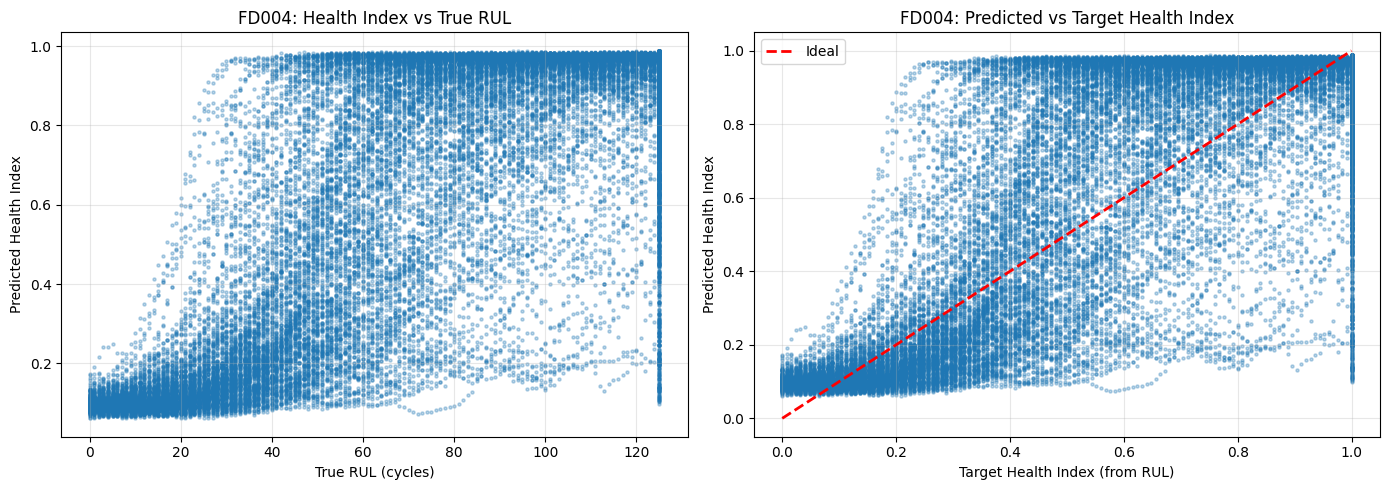


[FD004] Health Index Trajectories for 5 Sample Engines


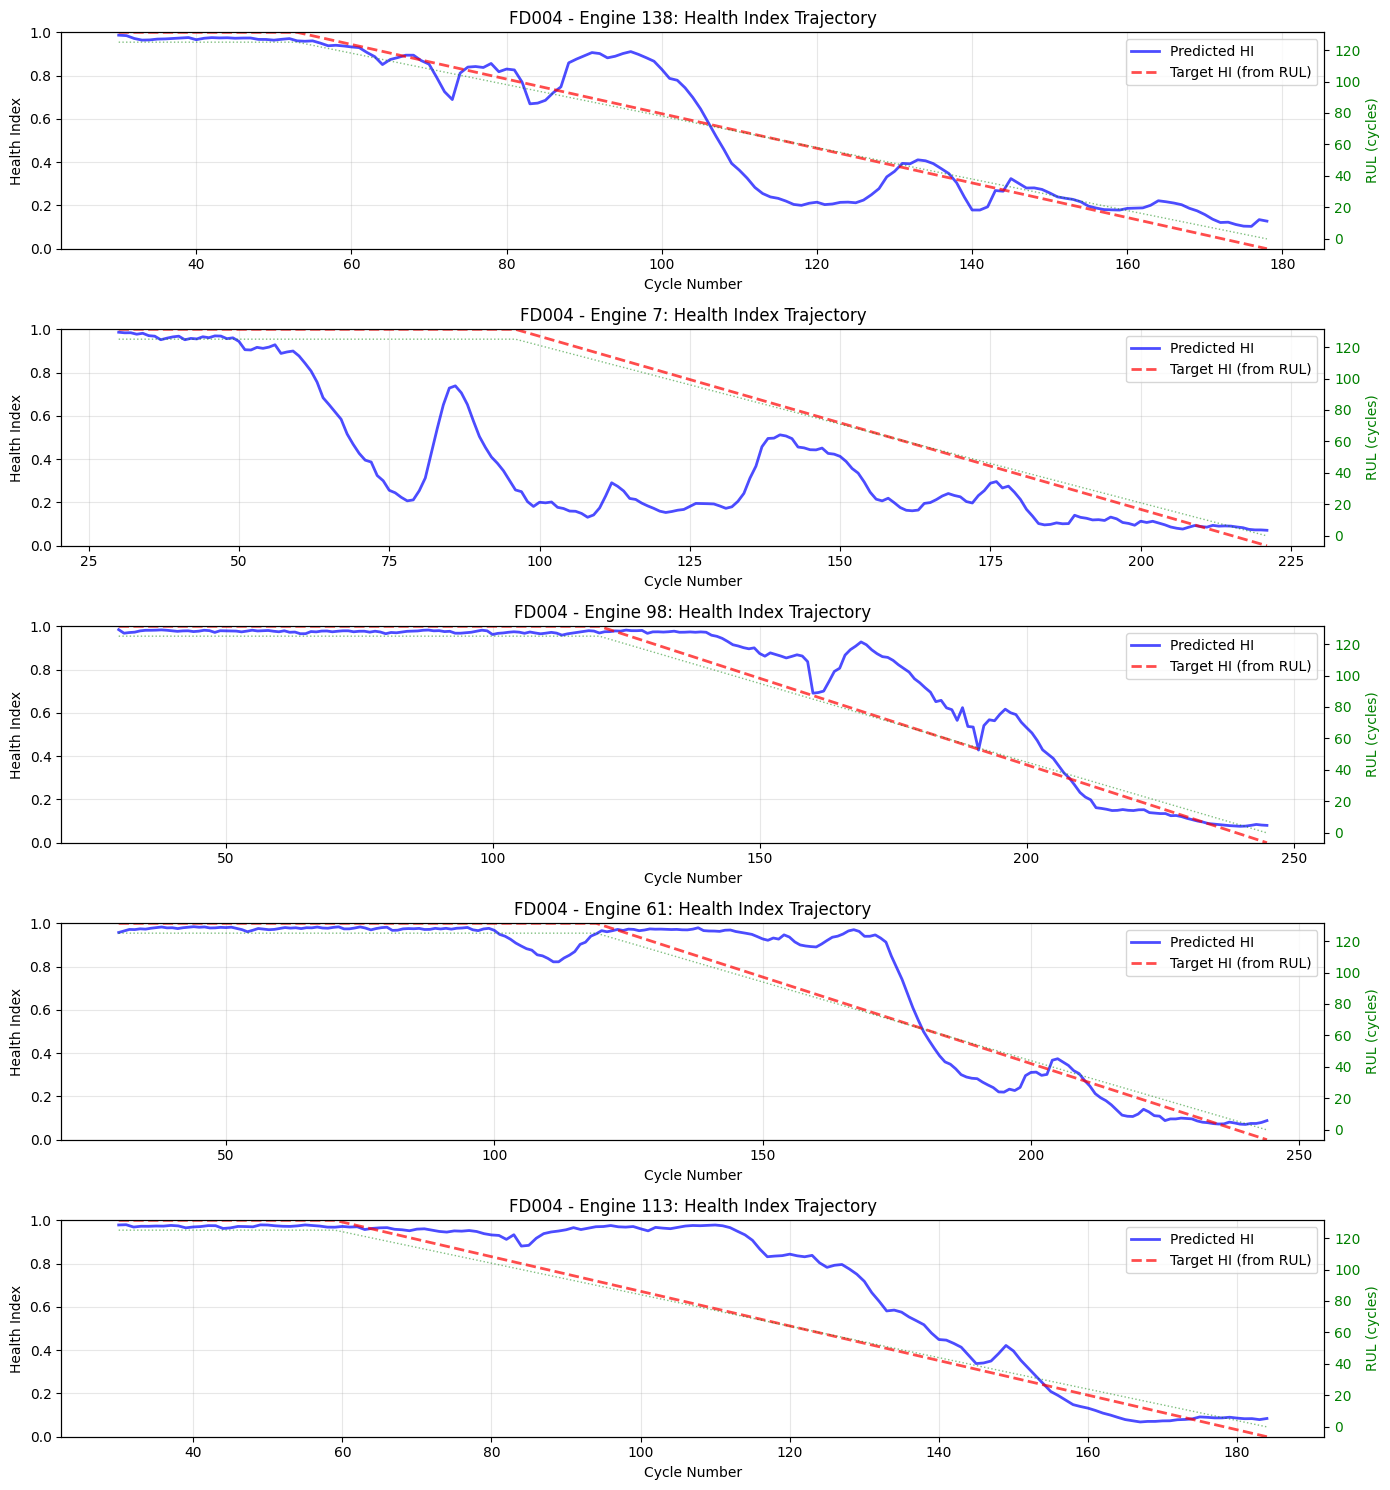


[FD004] Health Index trajectories plotted for 5 sample engines


In [7]:
# ===================================================================
# Health Index Analysis
# ===================================================================

if USE_HEALTH_HEAD:
    # Loop through all datasets
    for fd_id in FD_DATASETS:
        if "multi_task" not in results.get(fd_id, {}):
            print(f"\n[{fd_id}] Skipping - multi-task model not available")
            continue
            
        print("\n" + "=" * 80)
        print(f"Health Index Analysis for {fd_id}")
        print("=" * 80)
        
        model = results[fd_id]["multi_task"]["model"]
        scaler = results[fd_id]["multi_task"]["scaler"]
        feature_cols = results[fd_id]["multi_task"]["feature_cols"]

        # Load training data for trajectory analysis
        df_train_health, _, _ = load_cmapps_subset(
            fd_id,
            max_rul=None,
            clip_train=False,
            clip_test=True,
        )

        # Apply same feature engineering
        from src.config import PhysicsFeatureConfig
        physics_config = PhysicsFeatureConfig(
            use_core=True,
            use_extended=False,
            use_residuals=False,
            use_temporal_on_physics=False,
        )

        df_train_health = create_physical_features(
            df_train_health,
            physics_config=physics_config,
            unit_col="UnitNumber",
            cycle_col="TimeInCycles",
        )
        df_train_health = create_all_features(
            df_train_health,
            unit_col="UnitNumber",
            cycle_col="TimeInCycles",
            config=FEATURE_CONFIG,
            inplace=False,
        )

        # Build sequences
        X_health, y_health, unit_ids_health, cond_ids_health = build_full_eol_sequences_from_df(     
            df=df_train_health,
            feature_cols=feature_cols,
            past_len=TRAINING_CONFIG["past_len"],
            max_rul=TRAINING_CONFIG["max_rul"],
            unit_col="UnitNumber",
            cycle_col="TimeInCycles",
            rul_col="RUL",
        )

        # Apply scaling (handle both global scaler and condition-wise scalers)
        X_health_np = X_health.numpy()
        B, T, F = X_health_np.shape
        
        if isinstance(scaler, dict):
            # Condition-wise scaling
            X_health_scaled_list = []
            for i in range(B):
                cond_id = int(cond_ids_health[i])
                if cond_id in scaler:
                    x_sample = X_health_np[i]  # [past_len, num_features]
                    x_scaled = scaler[cond_id].transform(x_sample)
                    X_health_scaled_list.append(torch.from_numpy(x_scaled))
                else:
                    # Fallback: use first available scaler
                    if scaler:
                        x_sample = X_health_np[i]
                        first_scaler = list(scaler.values())[0]
                        x_scaled = first_scaler.transform(x_sample)
                        X_health_scaled_list.append(torch.from_numpy(x_scaled))
                    else:
                        X_health_scaled_list.append(torch.from_numpy(X_health_np[i]))
            X_health_scaled = torch.stack(X_health_scaled_list).float()
        else:
            # Global scaling
            X_health_flat = X_health_np.reshape(-1, F)
            X_health_scaled = scaler.transform(X_health_flat)
            X_health_scaled = torch.from_numpy(X_health_scaled.reshape(B, T, F)).float()

        # Get predictions (RUL + Health)
        model.eval()
        with torch.no_grad():
            X_health_scaled = X_health_scaled.to(device)
            rul_pred, health_last, health_seq = model(X_health_scaled)
            rul_pred = rul_pred.cpu().numpy()
            health_pred = health_last.cpu().numpy()  # Use health_last (final time step HI)                                                                         

        y_health_np = y_health.numpy()
        unit_ids_health_np = unit_ids_health.numpy()

        # Compute Health Index target (for comparison)
        HI_target = np.clip(y_health_np / MAX_RUL, 0.0, 1.0)

        print("\n" + "=" * 80)
        print(f"[{fd_id}] Health Index Statistics")
        print("=" * 80)
        print(f"Predicted Health Index:")
        print(f"  Mean: {health_pred.mean():.4f}")
        print(f"  Std: {health_pred.std():.4f}")
        print(f"  Min: {health_pred.min():.4f}")
        print(f"  Max: {health_pred.max():.4f}")
        print(f"\nTarget Health Index (from RUL):")
        print(f"  Mean: {HI_target.mean():.4f}")
        print(f"  Std: {HI_target.std():.4f}")
        print(f"  Min: {HI_target.min():.4f}")
        print(f"  Max: {HI_target.max():.4f}")
        print(f"\nHealth Index MSE: {np.mean((health_pred - HI_target)**2):.6f}")   
        print("=" * 80)

        # ===================================================================
        # Detection Horizon Analysis
        # ===================================================================
        from src.health_index_metrics import (
            compute_detection_horizon_per_engine,
            summarize_detection_horizon,
        )
        
        # For detection horizon, we'll use only the LAST sequence from each engine
        # (the one at EOL) to avoid issues with overlapping sequences
        # This gives us a clean trajectory from early cycles to EOL for each engine
        
        # Extract health_seq and build RUL sequence for each sample
        health_seq_np = health_seq.cpu().numpy()  # [B, T, 1] or [B, T]
        if health_seq_np.ndim == 3:
            health_seq_np = health_seq_np.squeeze(-1)  # [B, T]
        
        # Build RUL sequence for each sample (same logic as in training)
        # y_health_np contains RUL at last time step for each sample
        B, T = health_seq_np.shape
        
        # Find the last sequence index for each unit (lowest RUL = closest to EOL)
        unit_last_seq = {}  # unit_id -> (seq_idx, rul_last)
        
        for i in range(B):
            unit_id = int(unit_ids_health_np[i])
            rul_last = y_health_np[i]
            
            # Keep track of the sequence with the lowest RUL (closest to EOL)
            if unit_id not in unit_last_seq:
                unit_last_seq[unit_id] = (i, rul_last)
            else:
                _, prev_rul = unit_last_seq[unit_id]
                if rul_last < prev_rul:
                    unit_last_seq[unit_id] = (i, rul_last)
        
        # Now extract sequences for each unit and build trajectories
        hi_all = []
        rul_all = []
        unit_ids_all = []
        
        for unit_id, (seq_idx, rul_last) in unit_last_seq.items():
            # Build RUL sequence backwards from last RUL
            # Sequence goes from early (high RUL) to late (low RUL)
            # Note: Don't cap to MAX_RUL here - allow RUL to exceed MAX_RUL for early steps
            # since MAX_RUL is just a training cap, not a physical limit
            offsets = np.arange(T - 1, -1, -1, dtype=np.float32)  # [T]
            rul_seq_i = rul_last + offsets  # [T]
            rul_seq_i = np.maximum(rul_seq_i, 0.0)  # Only clip negative values, not upper bound
            
            # Get HI sequence
            hi_seq_i = health_seq_np[seq_idx]  # [T]
            
            # Append in temporal order (early -> late, high RUL -> low RUL)
            for t in range(T):
                hi_all.append(float(hi_seq_i[t]))
                rul_all.append(float(rul_seq_i[t]))
                unit_ids_all.append(unit_id)
        
        # Convert to numpy arrays
        hi_all = np.array(hi_all)
        rul_all = np.array(rul_all)
        unit_ids_all = np.array(unit_ids_all)
        
        # Compute detection horizon
        thresholds = [0.8, 0.5, 0.2, 0.1]
        horizons = compute_detection_horizon_per_engine(
            hi=hi_all,
            rul=rul_all,
            unit_ids=unit_ids_all,
            thresholds=thresholds,
        )
        
        # Summarize and print
        summary_df = summarize_detection_horizon(horizons)
        print("\n" + "=" * 80)
        print(f"[{fd_id}] Detection Horizon Summary (RUL at HI crossing)")
        print("=" * 80)
        print("Interpretation: RUL remaining when HI first crosses below threshold")
        print("(using running-min HI for monotonicity)")
        print("-" * 80)
        print(summary_df.to_string(index=False))
        print("=" * 80)
        
        # Save to CSV
        import os
        results_dir = "../results/health_index"
        os.makedirs(results_dir, exist_ok=True)
        csv_path = os.path.join(results_dir, f"{fd_id}_detection_horizon_hi.csv")
        summary_df.to_csv(csv_path, index=False)
        print(f"\n[{fd_id}] Saved detection horizon summary to: {csv_path}")

        # Plot: Health Index vs RUL
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Scatter: Predicted HI vs True RUL
        ax1 = axes[0]
        ax1.scatter(y_health_np, health_pred, alpha=0.3, s=5)
        ax1.set_xlabel("True RUL (cycles)")
        ax1.set_ylabel("Predicted Health Index")
        ax1.set_title(f"{fd_id}: Health Index vs True RUL")
        ax1.grid(True, alpha=0.3)

        # Scatter: Predicted HI vs Target HI
        ax2 = axes[1]
        ax2.scatter(HI_target, health_pred, alpha=0.3, s=5)
        max_hi = max(HI_target.max(), health_pred.max())
        ax2.plot([0, max_hi], [0, max_hi], 'r--', linewidth=2, label="Ideal")       
        ax2.set_xlabel("Target Health Index (from RUL)")
        ax2.set_ylabel("Predicted Health Index")
        ax2.set_title(f"{fd_id}: Predicted vs Target Health Index")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()

        try:
            from IPython.display import display
            display(fig)
        except (ImportError, NameError):
            plt.show()

        # Plot: Health Index Trajectories for Sample Engines
        print("\n" + "=" * 80)
        print(f"[{fd_id}] Health Index Trajectories for 5 Sample Engines")
        print("=" * 80)

        unique_units = np.unique(unit_ids_health_np)
        n_sample = min(5, len(unique_units))
        np.random.seed(42)
        sample_units = np.random.choice(unique_units, size=n_sample, replace=False) 

        fig, axes = plt.subplots(n_sample, 1, figsize=(14, 3 * n_sample))
        if n_sample == 1:
            axes = [axes]

        for idx, unit_id in enumerate(sample_units):
            ax = axes[idx]
            mask = unit_ids_health_np == unit_id

            # Get cycle numbers
            df_unit = df_train_health[df_train_health['UnitNumber'] == unit_id].sort_values('TimeInCycles')                                                         
            cycles = df_unit['TimeInCycles'].values

            # Align predictions with cycles
            if len(cycles) >= TRAINING_CONFIG["past_len"]:
                cycles_for_pred = cycles[TRAINING_CONFIG["past_len"]-1:]
                health_traj = health_pred[mask][:len(cycles_for_pred)]
                rul_traj = y_health_np[mask][:len(cycles_for_pred)]
                HI_target_traj = HI_target[mask][:len(cycles_for_pred)]
            else:
                cycles_for_pred = cycles
                health_traj = health_pred[mask][:len(cycles_for_pred)]
                rul_traj = y_health_np[mask][:len(cycles_for_pred)]
                HI_target_traj = HI_target[mask][:len(cycles_for_pred)]

            # Plot Health Index
            ax.plot(cycles_for_pred, health_traj, 'b-', label='Predicted HI', linewidth=2, alpha=0.7)                                                               
            ax.plot(cycles_for_pred, HI_target_traj, 'r--', label='Target HI (from RUL)', linewidth=2, alpha=0.7)                                                   
            ax.set_xlabel("Cycle Number")
            ax.set_ylabel("Health Index")
            ax.set_title(f"{fd_id} - Engine {int(unit_id)}: Health Index Trajectory")                                                                               
            ax.set_ylim([0, 1])
            ax.grid(True, alpha=0.3)
            ax.legend()

            # Add RUL info
            ax2 = ax.twinx()
            ax2.plot(cycles_for_pred, rul_traj, 'g:', label='True RUL', linewidth=1, alpha=0.5)                                                                     
            ax2.set_ylabel("RUL (cycles)", color='green')
            ax2.tick_params(axis='y', labelcolor='green')

        plt.tight_layout()

        try:
            from IPython.display import display
            display(fig)
        except (ImportError, NameError):
            plt.show()

        print(f"\n[{fd_id}] Health Index trajectories plotted for {n_sample} sample engines") 
        print("=" * 80)
else:
    print("Multi-task model not available. Please run training with USE_HEALTH_HEAD=True.")
